# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [36]:
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plot
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10
#from utils.grad_check import gradient_checking

%matplotlib inline

# Funções de Ativação

In [37]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

# Funções Auxiliares

In [38]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

# Funções de Custo

###### Para Regressão

In [39]:
def mae(y, y_pred, derivative=False):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    return np.mean(np.abs(y-y_pred))
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)/y.shape[0]
    return 0.5 * np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [40]:
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1-y_pred) * y.shape[0])
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    return -np.mean(y*np.log(y_sigmoid) + (1-y)*np.log(1-y_sigmoid))

###### Para Classificação Multiclasse

In [41]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

# Inicialização de Pesos

In [42]:
def zeros(rows, cols):
    return np.zeros((rows, cols))

def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    # normal com média 0 e stddev=sqrt(2.0/(out+inp))
    std_dev = np.sqrt(2.0 / (rows + cols))
    return std_dev * np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    # uniforme de [-limit, limit], limit = np.sqrt(6.0 / (out + inp))
    limit = np.sqrt(6.0 / (rows + cols))
    return 2*limit*np.random.rand(rows, cols) - limit

# Regularização

###### Dos Pesos

In [43]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return np.array([np.where(w >0, 1, w) for w in weights])
    return np.sum([np.sum(np.abs(w)) for w in weights])

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights**2)

# Batch Generator

In [44]:
def batch_sequential(x, y, batch_size=None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batches = x.shape[0] // batch_size
    
    for batch in range(n_batches):
        offset = batch_size * batch
        x_batch, y_batch = x[offset:offset+batch_size], y[offset:offset+batch_size]
        yield (x_batch, y_batch)
    
def batch_shuffle(x, y, batch_size=None):
    shuffle_index = np.random.permutation(range(x.shape[0]))
    return batch_sequential(x[shuffle_index], y[shuffle_index], batch_size)

# Learning Rate Decay

In [45]:
def none_decay(learning_rate, epoch, decay_rate, decay_step=1):
    return learning_rate

def time_based_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return 1.0 / (1 + decay_rate * epoch)

def exponential_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate**epoch

def staircase_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate**(epoch // decay_steps)

# Batch Normalization

In [46]:
def batchnorm_forward(layer, x, is_training=True):
    mu = np.mean(x, axis=0) if is_training else layer._pop_mean
    var = np.var(x, axis=0) if is_training else layer._pop_var
    x_norm = (x - mu) / np.sqrt(var + 1e-8)
    out = layer.gamma * x_norm + layer.beta

    if is_training:
        layer._pop_mean = layer.bn_decay * layer._pop_mean + (1.0-layer.bn_decay)*mu
        layer._pop_var = layer.bn_decay * layer._pop_var + (1.0-layer.bn_decay)*var
        layer._bn_cache = (x, x_norm, mu, var)
    return out

def batchnorm_backward(layer, dactivation):
    x, x_norm, mu, var = layer._bn_cache

    m = layer._activ_inp.shape[0]
    x_mu = x - mu
    std_inv = 1.0 / np.sqrt(var + 1e-8)

    dx_norm = dactivation * layer.gamma
    dvar = np.sum(dx_norm * x_mu, axis=0) * -0.5 * (std_inv**3)
    dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2.0 * x_mu, axis=0)

    dx = (dx_norm * std_inv) + (dvar * 2.0 * x_mu / m) + (dmu / m)
    layer._dgamma = np.sum(dactivation * x_norm, axis=0)
    layer._dbeta = np.sum(dactivation, axis=0)
    return dx

# Implementação 

In [47]:
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear, weights_initializer=random_normal, biases_initializer=ones, 
                 dropout_prob=0.0, reg_func=l2_regularization, reg_strength=0.0, batch_norm=False, bn_decay=0.9, 
                 is_trainable=True):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        self.batch_norm = batch_norm
        self.bn_decay = bn_decay
        self.gamma, self.beta = ones(1, output_dim), zeros(1, output_dim)
        self.is_trainable = is_trainable

        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        self._dropout_mask = None
        self._dgamma, self._dbeta = None, None
        self._pop_mean, self._pop_var = zeros(1, output_dim), zeros(1, output_dim)
        self._bn_cache = None

class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3, lr_decay_method=none_decay, lr_decay_rate=0.0, lr_decay_steps=1, 
                 momentum=0.0, patience=np.inf):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = self.lr_initial = learning_rate
        self.lr_decay_method = lr_decay_method
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_steps = lr_decay_steps
        self.momentum = momentum
        self.patience, self.waiting = patience, 0
        self._best_model, self._best_loss = self.layers, np.inf
        
    def fit(self, x_train, y_train, x_val=None, y_val=None, epochs=100, verbose=10, batch_gen=batch_sequential, 
            batch_size=None):
        x_val, y_val = (x_train, y_train) if (x_val is None or y_val is None) else (x_val, y_val)
        
        for epoch in range(epochs+1):
            self.learning_rate = self.lr_decay_method(self.lr_initial, epoch, self.lr_decay_rate, self.lr_decay_steps)
            
            for x_batch, y_batch in batch_gen(x_train, y_train, batch_size):
                y_pred = self.__feedforward(x_batch)
                self.__backprop(y_batch, y_pred)
                
                loss_val = self.cost_func(y_val, self.predict(x_val))
                if loss_val < self._best_loss:
                    self._best_model, self._best_loss = self.layers, loss_val
                    self.waiting = 0
                else:
                    self.waiting += 1
                    if self.waiting >= self.patience:
                        self.layers = self._best_model
                        return
                    
            if epoch % verbose == 0:
                loss_train = self.cost_func(y_train, self.predict(x_train))
                loss_reg = (1.0/y_train.shape[0])*np.sum([layer.reg_strength * layer.reg_func(layer.weights) for layer in 
                self.layers])
                print("epoch: {0:=4}/{1} loss_train: {2:.8f} + {3:.8f} = {4:.8f} loss_val: {5:.8f}".format(epoch, epochs, 
                loss_train, loss_reg, loss_train + loss_reg, loss_val))
        
    def predict(self, x):
        return self.__feedforward(x, is_training=False)
    
    def __feedforward(self, x, is_training=True):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0, 0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            y = batchnorm_forward(current_layer, y, is_training) if current_layer.batch_norm else y
            current_layer._dropout_mask = np.random.binomial(1, 1.0-current_layer.dropout_prob, y.shape) / (1.0 - 
            current_layer.dropout_prob)
            current_layer._activ_inp = y
            current_layer._activ_out = current_layer.activation(y) * (current_layer._dropout_mask if is_training else 1.0)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out
    
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta * layer._dropout_mask
            dactivation = batchnorm_backward(layer, dactivation) if layer.batch_norm else dactivation
            last_delta = np.dot(dactivation, layer.weights)
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0*dactivation.sum(axis=0, keepdims=True)
        
        for layer in reversed(self.layers):
            if layer.is_trainable:
                layer._dweights = layer._dweights + (1.0/y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights, 
                derivative=True)
                layer._prev_dweights = -self.learning_rate*layer._dweights + self.momentum*layer._prev_dweights
                layer.weights = layer.weights + layer._prev_dweights
                layer.biases = layer.biases - self.learning_rate*layer._dbiases
                if layer.batch_norm:
                    layer.gamma = layer.gamma - self.learning_rate*layer._dgamma
                    layer.beta = layer.beta - self.learning_rate*layer._dbeta

# Testes da Implementação

## Exemplos do Notebook da Intuição

### Exemplo 1

In [48]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) # destacar que eram para ser 2 bias - um para cada neurônio (1, 2)
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]]) # destacar que eram para ser 2 bias - um para cada neurônio (1, 2)

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs=0, verbose=1)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/0 loss_train: 0.14023572 + 0.00000000 = 0.14023572 loss_val: 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]


### Exemplo 2

In [49]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b

nn.fit(x, y, epochs=300, verbose=30)
for layer in nn.layers:
    print(layer.weights)

for layer in nn.layers:
    layer.is_trainable = False

print("Trainable == FALSE")
nn.fit(x, y, epochs=1000, verbose=100)
for layer in nn.layers:
    print(layer.weights)

epoch:    0/300 loss_train: 1.14054966 + 0.00000000 = 1.14054966 loss_val: 1.14054966
epoch:   30/300 loss_train: 0.59630022 + 0.00000000 = 0.59630022 loss_val: 0.59630022
epoch:   60/300 loss_train: 0.36031189 + 0.00000000 = 0.36031189 loss_val: 0.36031189
epoch:   90/300 loss_train: 0.24668884 + 0.00000000 = 0.24668884 loss_val: 0.24668884
epoch:  120/300 loss_train: 0.18386202 + 0.00000000 = 0.18386202 loss_val: 0.18386202
epoch:  150/300 loss_train: 0.14510157 + 0.00000000 = 0.14510157 loss_val: 0.14510157
epoch:  180/300 loss_train: 0.11918285 + 0.00000000 = 0.11918285 loss_val: 0.11918285
epoch:  210/300 loss_train: 0.10078511 + 0.00000000 = 0.10078511 loss_val: 0.10078511
epoch:  240/300 loss_train: 0.08712037 + 0.00000000 = 0.08712037 loss_val: 0.08712037
epoch:  270/300 loss_train: 0.07660623 + 0.00000000 = 0.07660623 loss_val: 0.07660623
epoch:  300/300 loss_train: 0.06828531 + 0.00000000 = 0.06828531 loss_val: 0.06828531
[[0.10083595 0.2016719  0.30585165]
 [0.30086971 0.201

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

(100, 2)
(100, 1) (100, 1)


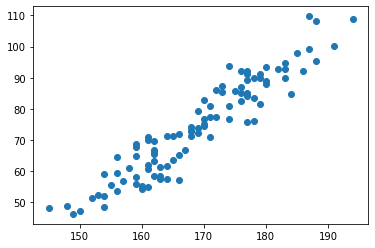

In [115]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)
plt.scatter(x, y)

-1.0 0.9999999999999991


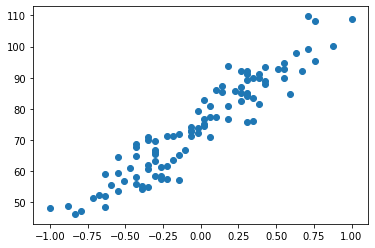

In [116]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())
plt.scatter(x, y)

epoch:    0/1000 loss_train: 2744.32591061 + 0.00000000 = 2744.32591061 loss_val: 2744.32591061
epoch:  100/1000 loss_train: 438.25723797 + 0.00000000 = 438.25723797 loss_val: 438.25723797
epoch:  200/1000 loss_train: 110.99742122 + 0.00000000 = 110.99742122 loss_val: 110.99742122
epoch:  300/1000 loss_train: 54.38628005 + 0.00000000 = 54.38628005 loss_val: 54.38628005
epoch:  400/1000 loss_train: 37.99665010 + 0.00000000 = 37.99665010 loss_val: 37.99665010
epoch:  500/1000 loss_train: 29.74093774 + 0.00000000 = 29.74093774 loss_val: 29.74093774
epoch:  600/1000 loss_train: 24.46604974 + 0.00000000 = 24.46604974 loss_val: 24.46604974
epoch:  700/1000 loss_train: 20.89169408 + 0.00000000 = 20.89169408 loss_val: 20.89169408
epoch:  800/1000 loss_train: 18.44025123 + 0.00000000 = 18.44025123 loss_val: 18.44025123
epoch:  900/1000 loss_train: 16.75495508 + 0.00000000 = 16.75495508 loss_val: 16.75495508
epoch: 1000/1000 loss_train: 15.59582656 + 0.00000000 = 15.59582656 loss_val: 15.5958265

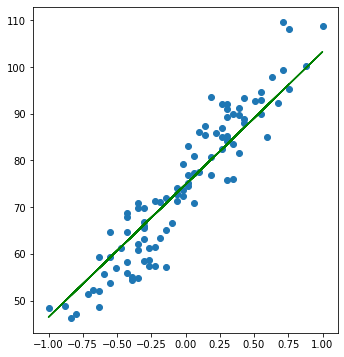

In [52]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [53]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


[-1.] [1.]


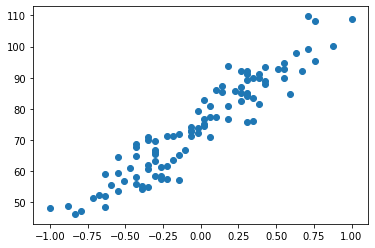

In [117]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))
plt.scatter(x, y)

epoch:    0/2000 loss_train: 2756.30571791 + 0.00000000 = 2756.30571791 loss_val: 2756.30571791
epoch:  200/2000 loss_train: 118.78076038 + 0.00000000 = 118.78076038 loss_val: 118.78076038
epoch:  400/2000 loss_train: 41.71729661 + 0.00000000 = 41.71729661 loss_val: 41.71729661
epoch:  600/2000 loss_train: 26.22718865 + 0.00000000 = 26.22718865 loss_val: 26.22718865
epoch:  800/2000 loss_train: 19.27356351 + 0.00000000 = 19.27356351 loss_val: 19.27356351
epoch: 1000/2000 loss_train: 15.99011665 + 0.00000000 = 15.99011665 loss_val: 15.99011665
epoch: 1200/2000 loss_train: 14.43664213 + 0.00000000 = 14.43664213 loss_val: 14.43664213
epoch: 1400/2000 loss_train: 13.70160260 + 0.00000000 = 13.70160260 loss_val: 13.70160260
epoch: 1600/2000 loss_train: 13.35381149 + 0.00000000 = 13.35381149 loss_val: 13.35381149
epoch: 1800/2000 loss_train: 13.18925071 + 0.00000000 = 13.18925071 loss_val: 13.18925071
epoch: 2000/2000 loss_train: 13.11138717 + 0.00000000 = 13.11138717 loss_val: 13.11138717
[

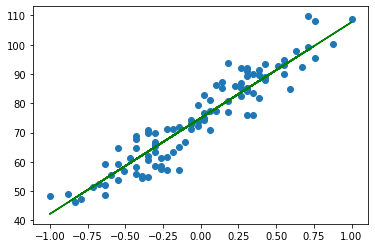

In [120]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Quadrática

(100, 1) (100, 1)


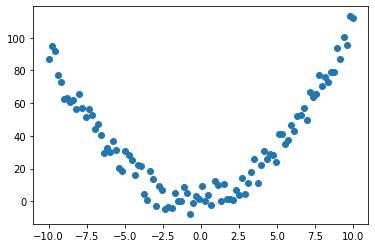

In [127]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)
plt.scatter(x,y)

[-1.] [1.]


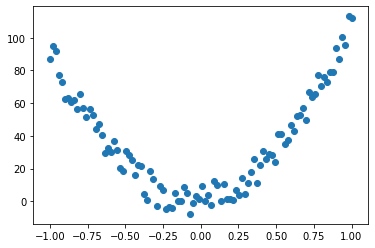

In [128]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))
plt.scatter(x, y)

epoch:    0/1000 loss_train: 907.00472877 + 0.00000000 = 907.00472877 loss_val: 907.00472877
epoch:  100/1000 loss_train: 123.68093925 + 0.00000000 = 123.68093925 loss_val: 123.68093925
epoch:  200/1000 loss_train: 45.06055032 + 0.00000000 = 45.06055032 loss_val: 45.06055032
epoch:  300/1000 loss_train: 30.86377069 + 0.00000000 = 30.86377069 loss_val: 30.86377069
epoch:  400/1000 loss_train: 25.22798468 + 0.00000000 = 25.22798468 loss_val: 25.22798468
epoch:  500/1000 loss_train: 22.39942187 + 0.00000000 = 22.39942187 loss_val: 22.39942187
epoch:  600/1000 loss_train: 20.66783748 + 0.00000000 = 20.66783748 loss_val: 20.66783748
epoch:  700/1000 loss_train: 20.03623174 + 0.00000000 = 20.03623174 loss_val: 20.03623174
epoch:  800/1000 loss_train: 22.12285891 + 0.00000000 = 22.12285891 loss_val: 22.12285891
epoch:  900/1000 loss_train: 18.78208335 + 0.00000000 = 18.78208335 loss_val: 18.78208335
epoch: 1000/1000 loss_train: 18.04810122 + 0.00000000 = 18.04810122 loss_val: 18.04810122


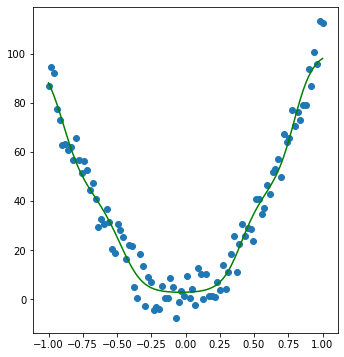

In [129]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

In [122]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)

(100, 1) (100, 1)


[-1.] [1.]


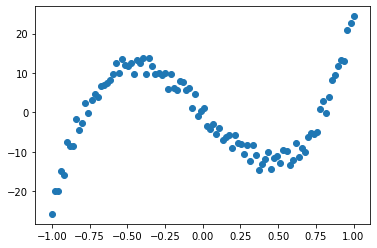

In [123]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))
plt.scatter(x, y)

epoch:    0/1000 loss_train: 56.05958656 + 0.00000000 = 56.05958656 loss_val: 56.05958656
epoch:  100/1000 loss_train: 29.32975488 + 0.00000000 = 29.32975488 loss_val: 29.32975488
epoch:  200/1000 loss_train: 13.85876931 + 0.00000000 = 13.85876931 loss_val: 13.85876931
epoch:  300/1000 loss_train: 7.75441096 + 0.00000000 = 7.75441096 loss_val: 7.75441096
epoch:  400/1000 loss_train: 5.27770934 + 0.00000000 = 5.27770934 loss_val: 5.27770934
epoch:  500/1000 loss_train: 4.15888020 + 0.00000000 = 4.15888020 loss_val: 4.15888020
epoch:  600/1000 loss_train: 3.53832391 + 0.00000000 = 3.53832391 loss_val: 3.53832391
epoch:  700/1000 loss_train: 3.09187165 + 0.00000000 = 3.09187165 loss_val: 3.09187165
epoch:  800/1000 loss_train: 2.71567562 + 0.00000000 = 2.71567562 loss_val: 2.71567562
epoch:  900/1000 loss_train: 2.27798895 + 0.00000000 = 2.27798895 loss_val: 2.27798895
epoch: 1000/1000 loss_train: 2.00873605 + 0.00000000 = 2.00873605 loss_val: 2.00873605


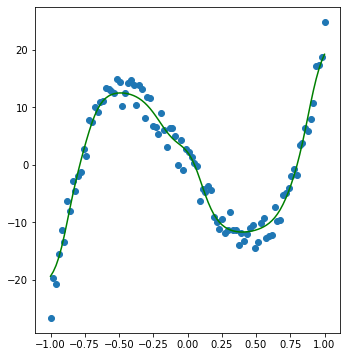

In [63]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

In [131]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)

(100, 1) (100, 1)


[-1.] [1.]


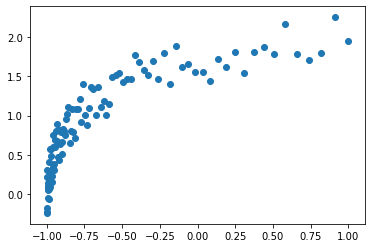

In [132]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))
plt.scatter(x, y)

epoch:    0/1000 loss_train: 10.08112665 + 0.00000000 = 10.08112665 loss_val: 10.08112665
epoch:  100/1000 loss_train: 0.20182613 + 0.00000000 = 0.20182613 loss_val: 0.20182613
epoch:  200/1000 loss_train: 0.06606665 + 0.00000000 = 0.06606665 loss_val: 0.06606665
epoch:  300/1000 loss_train: 0.05211917 + 0.00000000 = 0.05211917 loss_val: 0.05211917
epoch:  400/1000 loss_train: 0.04822178 + 0.00000000 = 0.04822178 loss_val: 0.04822178
epoch:  500/1000 loss_train: 0.04572329 + 0.00000000 = 0.04572329 loss_val: 0.04572329
epoch:  600/1000 loss_train: 0.04367998 + 0.00000000 = 0.04367998 loss_val: 0.04367998
epoch:  700/1000 loss_train: 0.04193059 + 0.00000000 = 0.04193059 loss_val: 0.04193059
epoch:  800/1000 loss_train: 0.04041128 + 0.00000000 = 0.04041128 loss_val: 0.04041128
epoch:  900/1000 loss_train: 0.03907868 + 0.00000000 = 0.03907868 loss_val: 0.03907868
epoch: 1000/1000 loss_train: 0.03789946 + 0.00000000 = 0.03789946 loss_val: 0.03789946


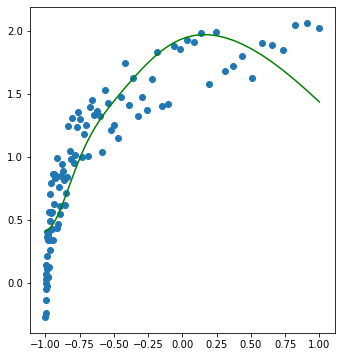

In [66]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-4, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

In [133]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


[-1.] [1.]


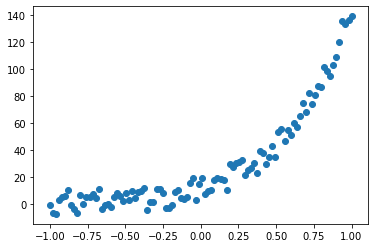

In [134]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))
plt.scatter(x, y)

epoch:    0/1000 loss_train: 956.29357098 + 0.00000000 = 956.29357098 loss_val: 956.29357098
epoch:  100/1000 loss_train: 319.88532411 + 0.00000000 = 319.88532411 loss_val: 319.88532411
epoch:  200/1000 loss_train: 169.72814678 + 0.00000000 = 169.72814678 loss_val: 169.72814678
epoch:  300/1000 loss_train: 146.13143544 + 0.00000000 = 146.13143544 loss_val: 146.13143544
epoch:  400/1000 loss_train: 135.88750015 + 0.00000000 = 135.88750015 loss_val: 135.88750015
epoch:  500/1000 loss_train: 127.60363258 + 0.00000000 = 127.60363258 loss_val: 127.60363258
epoch:  600/1000 loss_train: 120.18256199 + 0.00000000 = 120.18256199 loss_val: 120.18256199
epoch:  700/1000 loss_train: 113.26656389 + 0.00000000 = 113.26656389 loss_val: 113.26656389
epoch:  800/1000 loss_train: 107.09007243 + 0.00000000 = 107.09007243 loss_val: 107.09007243
epoch:  900/1000 loss_train: 101.50888085 + 0.00000000 = 101.50888085 loss_val: 101.50888085
epoch: 1000/1000 loss_train: 96.51295948 + 0.00000000 = 96.51295948 lo

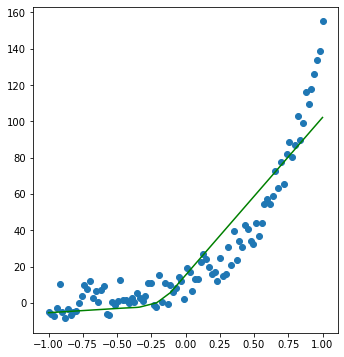

In [69]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

In [137]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 loss_train: 0.99987581 + 0.02104399 = 1.02091981 loss_val: 0.99987581
epoch: 1000/5000 loss_train: 0.05521337 + 0.12549761 = 0.18071098 loss_val: 0.05521337
epoch: 2000/5000 loss_train: 0.05203555 + 0.12856958 = 0.18060513 loss_val: 0.05203555
epoch: 3000/5000 loss_train: 0.05183367 + 0.12877101 = 0.18060468 loss_val: 0.05183367
epoch: 4000/5000 loss_train: 0.05182006 + 0.12878462 = 0.18060468 loss_val: 0.05182006
epoch: 5000/5000 loss_train: 0.05181913 + 0.12878554 = 0.18060468 loss_val: 0.05181913
[[5.15142178 5.15142178]] [[-8.10225154]]
Predições:
[[3.02764782e-04]
 [4.96973094e-02]
 [4.96973094e-02]
 [9.00302662e-01]]
Acurácia: 100.00%


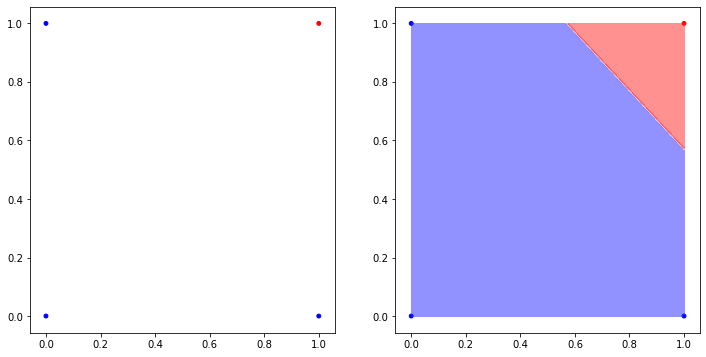

In [138]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid, reg_func=l1_regularization, reg_strength=0.05))

nn.fit(x, y, epochs=5000, verbose=1000)

print(nn.layers[0].weights, nn.layers[0].biases)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Porta XOR

In [78]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 loss_train: 1.26224183 + 0.00000000 = 1.26224183 loss_val: 1.26224183
epoch: 1000/5000 loss_train: 0.02986197 + 0.00000000 = 0.02986197 loss_val: 0.02986197
epoch: 2000/5000 loss_train: 0.01126388 + 0.00000000 = 0.01126388 loss_val: 0.01126388
epoch: 3000/5000 loss_train: 0.00687724 + 0.00000000 = 0.00687724 loss_val: 0.00687724
epoch: 4000/5000 loss_train: 0.00493750 + 0.00000000 = 0.00493750 loss_val: 0.00493750
epoch: 5000/5000 loss_train: 0.00384723 + 0.00000000 = 0.00384723 loss_val: 0.00384723
Predições:
[[0.00437045]
 [0.99678851]
 [0.99678891]
 [0.00456551]]
Acurácia: 100.00%


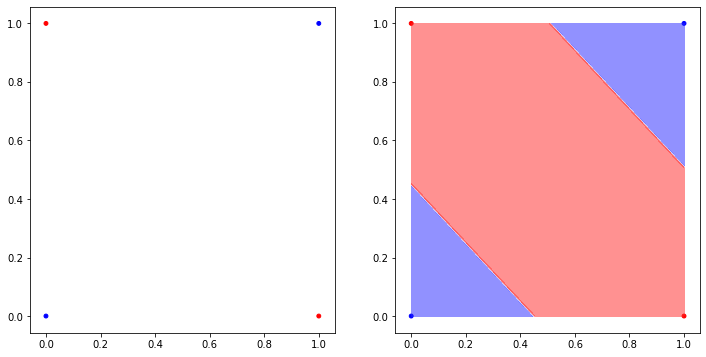

In [81]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 2 Clusters

(100, 2) (100, 1)


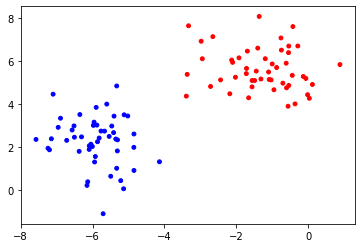

In [144]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000 loss_train: 0.77580909 + 0.00000000 = 0.77580909 loss_val: 0.77580909
epoch: 1000/5000 loss_train: 0.63548911 + 0.00000000 = 0.63548911 loss_val: 0.63548911
epoch: 2000/5000 loss_train: 0.58169053 + 0.00000000 = 0.58169053 loss_val: 0.58169053
epoch: 3000/5000 loss_train: 0.56096923 + 0.00000000 = 0.56096923 loss_val: 0.56096923
epoch: 4000/5000 loss_train: 0.54912221 + 0.00000000 = 0.54912221 loss_val: 0.54912221
epoch: 5000/5000 loss_train: 0.54146617 + 0.00000000 = 0.54146617 loss_val: 0.54146617
Acurácia: 99.00%


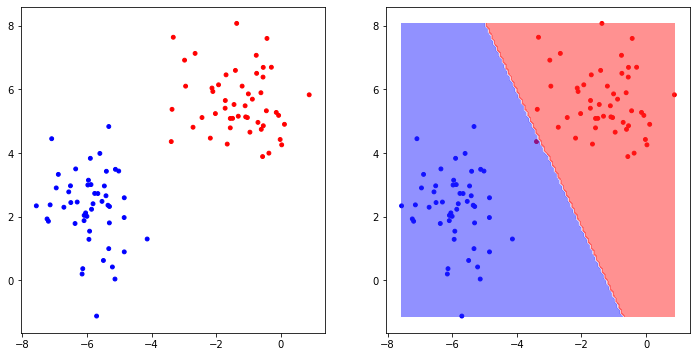

In [84]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 4 Clusters

(500, 2) (500, 1)


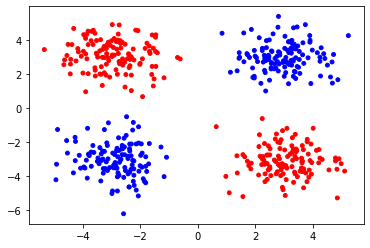

In [146]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/500 loss_train: 0.63793375 + 0.00000000 = 0.63793375 loss_val: 0.63793375
epoch:  100/500 loss_train: 0.20080575 + 0.00000000 = 0.20080575 loss_val: 0.20080575
epoch:  200/500 loss_train: 0.11468903 + 0.00000000 = 0.11468903 loss_val: 0.11468903
epoch:  300/500 loss_train: 0.07764049 + 0.00000000 = 0.07764049 loss_val: 0.07764049
epoch:  400/500 loss_train: 0.05759010 + 0.00000000 = 0.05759010 loss_val: 0.05759010
epoch:  500/500 loss_train: 0.04509202 + 0.00000000 = 0.04509202 loss_val: 0.04509202
Acurácia: 99.80%


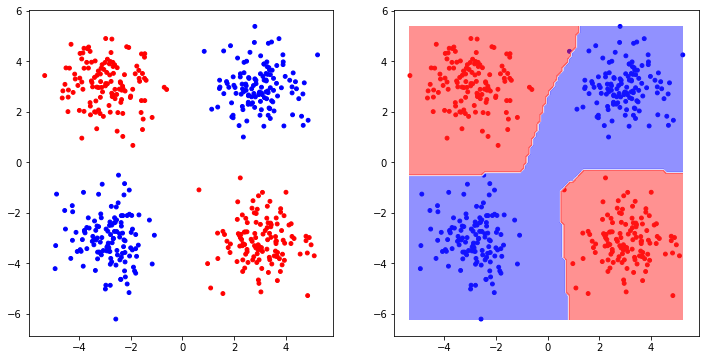

In [90]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=500, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

(500, 2) (500, 1)


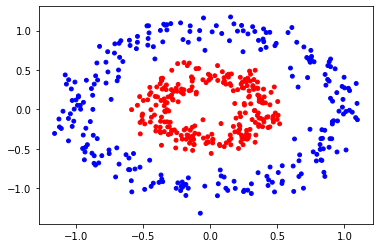

In [147]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: 3.86455347 + 0.00000000 = 3.86455347 loss_val: 3.86455347
epoch:  100/1000 loss_train: 0.59520963 + 0.00000000 = 0.59520963 loss_val: 0.59520963
epoch:  200/1000 loss_train: 0.45751612 + 0.00000000 = 0.45751612 loss_val: 0.45751612
epoch:  300/1000 loss_train: 0.34594008 + 0.00000000 = 0.34594008 loss_val: 0.34594008
epoch:  400/1000 loss_train: 0.26019729 + 0.00000000 = 0.26019729 loss_val: 0.26019729
epoch:  500/1000 loss_train: 0.17764741 + 0.00000000 = 0.17764741 loss_val: 0.17764741
epoch:  600/1000 loss_train: 0.10134960 + 0.00000000 = 0.10134960 loss_val: 0.10134960
epoch:  700/1000 loss_train: 0.06080824 + 0.00000000 = 0.06080824 loss_val: 0.06080824
epoch:  800/1000 loss_train: 0.04307098 + 0.00000000 = 0.04307098 loss_val: 0.04307098
epoch:  900/1000 loss_train: 0.03290193 + 0.00000000 = 0.03290193 loss_val: 0.03290193
epoch: 1000/1000 loss_train: 0.02691006 + 0.00000000 = 0.02691006 loss_val: 0.02691006
Acurácia: 99.80%


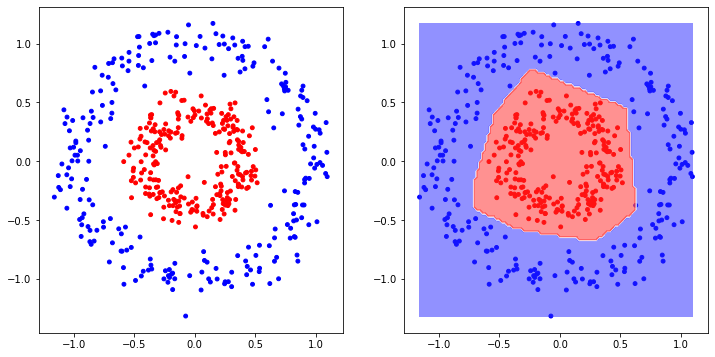

In [99]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=0.01, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

(200, 2) (200, 1)


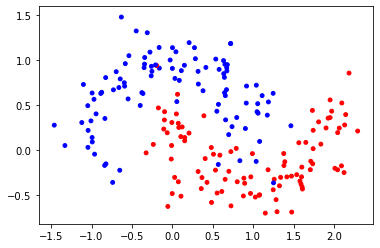

In [114]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/2000 loss_train: 0.39848105 + 0.00000000 = 0.39848105 loss_val: 0.39848105
epoch:  200/2000 loss_train: 0.22962995 + 0.00000000 = 0.22962995 loss_val: 0.22962995
epoch:  400/2000 loss_train: 0.19805249 + 0.00000000 = 0.19805249 loss_val: 0.19805249
epoch:  600/2000 loss_train: 0.17271442 + 0.00000000 = 0.17271442 loss_val: 0.17271442
epoch:  800/2000 loss_train: 0.15157826 + 0.00000000 = 0.15157826 loss_val: 0.15157826
epoch: 1000/2000 loss_train: 0.13483748 + 0.00000000 = 0.13483748 loss_val: 0.13483748
epoch: 1200/2000 loss_train: 0.12192006 + 0.00000000 = 0.12192006 loss_val: 0.12192006
epoch: 1400/2000 loss_train: 0.11199090 + 0.00000000 = 0.11199090 loss_val: 0.11199090
epoch: 1600/2000 loss_train: 0.10429409 + 0.00000000 = 0.10429409 loss_val: 0.10429409
epoch: 1800/2000 loss_train: 0.09824269 + 0.00000000 = 0.09824269 loss_val: 0.09824269
epoch: 2000/2000 loss_train: 0.09340663 + 0.00000000 = 0.09340663 loss_val: 0.09340663
Acurácia: 96.50%


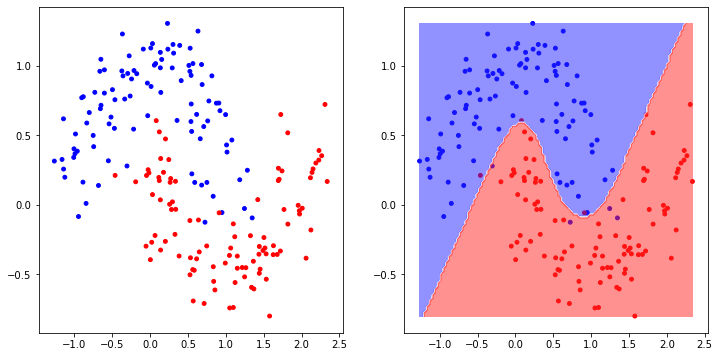

In [108]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=2000, verbose=200)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

(200, 2) (200, 1)


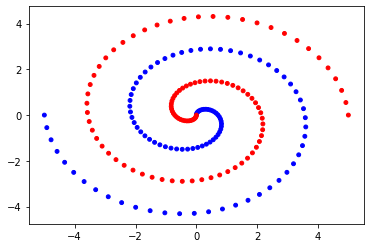

In [148]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000 loss_train: 2.21180815 + 0.00000000 = 2.21180815 loss_val: 2.21180815
epoch:  500/5000 loss_train: 0.23923689 + 0.00000000 = 0.23923689 loss_val: 0.23923689
epoch: 1000/5000 loss_train: 0.13157014 + 0.00000000 = 0.13157014 loss_val: 0.13157014
epoch: 1500/5000 loss_train: 0.07638701 + 0.00000000 = 0.07638701 loss_val: 0.07638701
epoch: 2000/5000 loss_train: 0.05199140 + 0.00000000 = 0.05199140 loss_val: 0.05199140
epoch: 2500/5000 loss_train: 0.03944537 + 0.00000000 = 0.03944537 loss_val: 0.03944537
epoch: 3000/5000 loss_train: 0.03193566 + 0.00000000 = 0.03193566 loss_val: 0.03193566
epoch: 3500/5000 loss_train: 0.02716334 + 0.00000000 = 0.02716334 loss_val: 0.02716334
epoch: 4000/5000 loss_train: 0.02387011 + 0.00000000 = 0.02387011 loss_val: 0.02387011
epoch: 4500/5000 loss_train: 0.02146849 + 0.00000000 = 0.02146849 loss_val: 0.02146849
epoch: 5000/5000 loss_train: 0.01964082 + 0.00000000 = 0.01964082 loss_val: 0.01964082
Acurácia: 99.50%


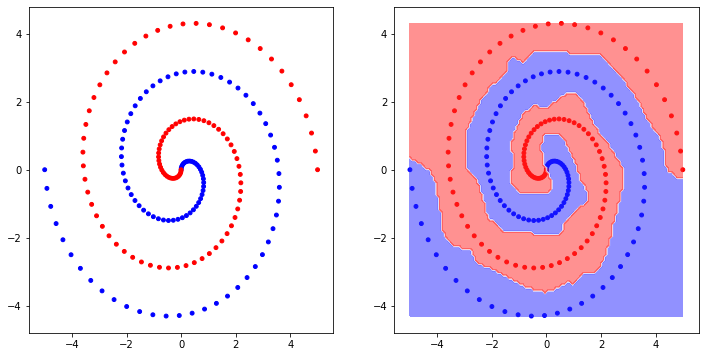

In [113]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=500)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

(300, 2) (300, 1)


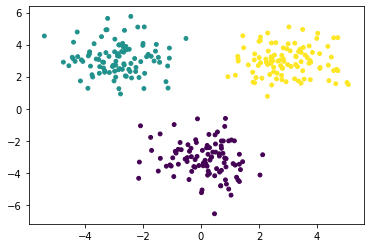

In [152]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [153]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


epoch:    0/1000 loss_train: 0.58071475 + 0.00285701 = 0.58357176 loss_val: 0.58071475
epoch:  100/1000 loss_train: 0.30372854 + 0.00302906 = 0.30675760 loss_val: 0.30372854
epoch:  200/1000 loss_train: 0.25090379 + 0.00306458 = 0.25396836 loss_val: 0.25090379
epoch:  300/1000 loss_train: 0.20990618 + 0.00308901 = 0.21299519 loss_val: 0.20990618
epoch:  400/1000 loss_train: 0.17795520 + 0.00310889 = 0.18106409 loss_val: 0.17795520
epoch:  500/1000 loss_train: 0.15287683 + 0.00312624 = 0.15600307 loss_val: 0.15287683
epoch:  600/1000 loss_train: 0.13298700 + 0.00314200 = 0.13612901 loss_val: 0.13298700
epoch:  700/1000 loss_train: 0.11702037 + 0.00315666 = 0.12017703 loss_val: 0.11702037
epoch:  800/1000 loss_train: 0.10403996 + 0.00317048 = 0.10721045 loss_val: 0.10403996
epoch:  900/1000 loss_train: 0.09335527 + 0.00318359 = 0.09653886 loss_val: 0.09335527
epoch: 1000/1000 loss_train: 0.08445729 + 0.00319607 = 0.08765336 loss_val: 0.08445729
[[ 0.27707061 -3.09704494]
 [-1.2427214   0

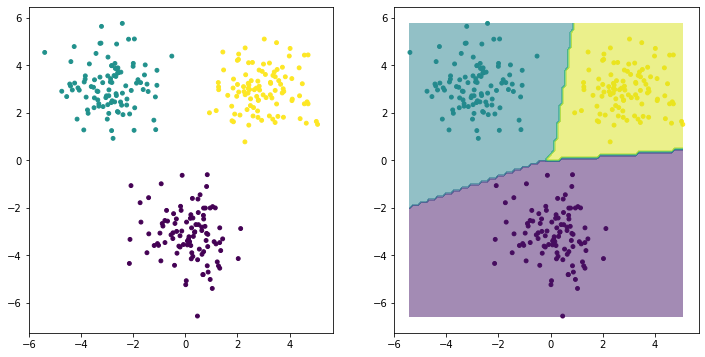

In [154]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu, reg_func=l2_regularization, reg_strength=0.1))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=0.1))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

for layer in nn.layers:
    print(layer.weights)
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

(400, 2) (400, 1)


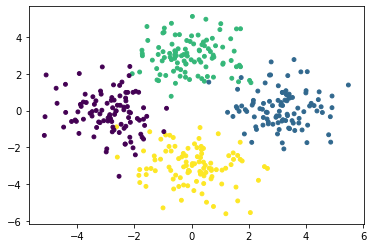

In [155]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [156]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


epoch:    0/1000 loss_train: 3.10747526 + 0.00000000 = 3.10747526 loss_val: 3.10747526
epoch:  100/1000 loss_train: 0.10933413 + 0.00000000 = 0.10933413 loss_val: 0.10933413
epoch:  200/1000 loss_train: 0.09689131 + 0.00000000 = 0.09689131 loss_val: 0.09689131
epoch:  300/1000 loss_train: 0.09159379 + 0.00000000 = 0.09159379 loss_val: 0.09159379
epoch:  400/1000 loss_train: 0.08839901 + 0.00000000 = 0.08839901 loss_val: 0.08839901
epoch:  500/1000 loss_train: 0.08619925 + 0.00000000 = 0.08619925 loss_val: 0.08619925
epoch:  600/1000 loss_train: 0.08450622 + 0.00000000 = 0.08450622 loss_val: 0.08450622
epoch:  700/1000 loss_train: 0.08312761 + 0.00000000 = 0.08312761 loss_val: 0.08312761
epoch:  800/1000 loss_train: 0.08198296 + 0.00000000 = 0.08198296 loss_val: 0.08198296
epoch:  900/1000 loss_train: 0.08099437 + 0.00000000 = 0.08099437 loss_val: 0.08099437
epoch: 1000/1000 loss_train: 0.08011943 + 0.00000000 = 0.08011943 loss_val: 0.08011943
Acurácia: 96.75%


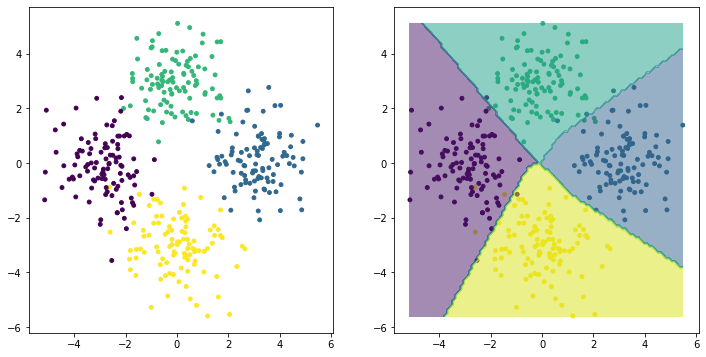

In [157]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

(500, 2) (500, 1)


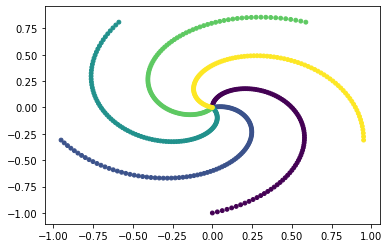

In [158]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [159]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


epoch:    0/1000 loss_train: 5.78830585 + 0.00000000 = 5.78830585 loss_val: 5.78830585
epoch:  100/1000 loss_train: 0.67069245 + 0.00000000 = 0.67069245 loss_val: 0.67069245
epoch:  200/1000 loss_train: 0.50414927 + 0.00000000 = 0.50414927 loss_val: 0.50414927
epoch:  300/1000 loss_train: 0.41206172 + 0.00000000 = 0.41206172 loss_val: 0.41206172
epoch:  400/1000 loss_train: 0.36419981 + 0.00000000 = 0.36419981 loss_val: 0.36419981
epoch:  500/1000 loss_train: 0.33785704 + 0.00000000 = 0.33785704 loss_val: 0.33785704
epoch:  600/1000 loss_train: 0.33031655 + 0.00000000 = 0.33031655 loss_val: 0.33031655
epoch:  700/1000 loss_train: 0.39078944 + 0.00000000 = 0.39078944 loss_val: 0.39078944
epoch:  800/1000 loss_train: 0.29080578 + 0.00000000 = 0.29080578 loss_val: 0.29080578
epoch:  900/1000 loss_train: 0.27881570 + 0.00000000 = 0.27881570 loss_val: 0.27881570
epoch: 1000/1000 loss_train: 0.42504065 + 0.00000000 = 0.42504065 loss_val: 0.42504065
Acurácia: 85.00%


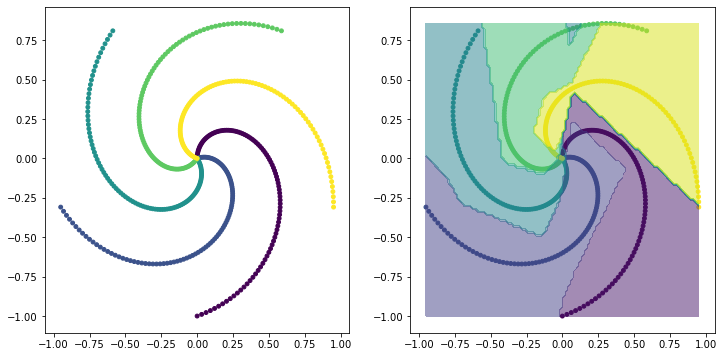

In [160]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

(100, 2) (100, 1)


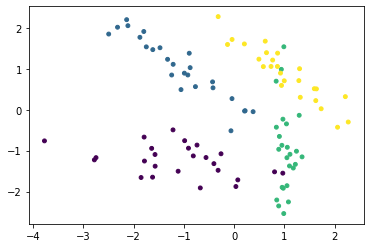

In [161]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, 
random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [162]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


epoch:    0/1000 loss_train: 1.44480763 + 0.00000000 = 1.44480763 loss_val: 1.44480763
epoch:  100/1000 loss_train: 0.31950113 + 0.00000000 = 0.31950113 loss_val: 0.31950113
epoch:  200/1000 loss_train: 0.25688706 + 0.00000000 = 0.25688706 loss_val: 0.25688706
epoch:  300/1000 loss_train: 0.23161660 + 0.00000000 = 0.23161660 loss_val: 0.23161660
epoch:  400/1000 loss_train: 0.21720403 + 0.00000000 = 0.21720403 loss_val: 0.21720403
epoch:  500/1000 loss_train: 0.20573783 + 0.00000000 = 0.20573783 loss_val: 0.20573783
epoch:  600/1000 loss_train: 0.19715062 + 0.00000000 = 0.19715062 loss_val: 0.19715062
epoch:  700/1000 loss_train: 0.19002907 + 0.00000000 = 0.19002907 loss_val: 0.19002907
epoch:  800/1000 loss_train: 0.18423954 + 0.00000000 = 0.18423954 loss_val: 0.18423954
epoch:  900/1000 loss_train: 0.17924084 + 0.00000000 = 0.17924084 loss_val: 0.17924084
epoch: 1000/1000 loss_train: 0.17506161 + 0.00000000 = 0.17506161 loss_val: 0.17506161
Acurácia: 93.00%


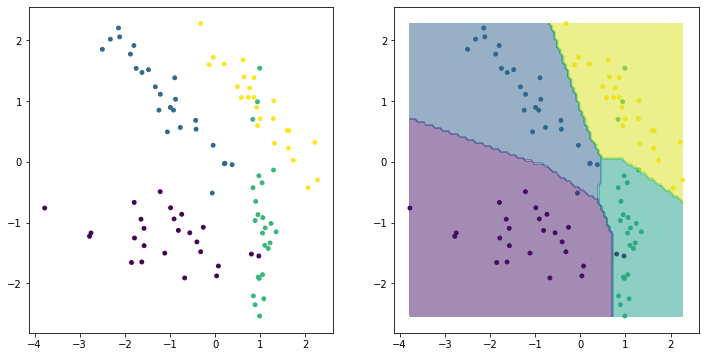

In [163]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Iris Dataset

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


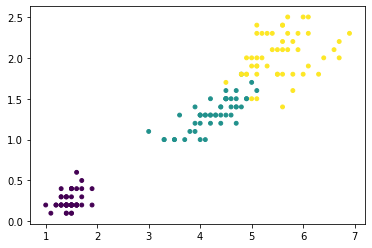

In [167]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [168]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


epoch:    0/5000 loss_train: 24.16230971 + 0.00000000 = 24.16230971 loss_val: 24.16230971
epoch:  500/5000 loss_train: 0.62004611 + 0.00000000 = 0.62004611 loss_val: 0.62004611
epoch: 1000/5000 loss_train: 0.54489126 + 0.00000000 = 0.54489126 loss_val: 0.54489126
epoch: 1500/5000 loss_train: 0.51495376 + 0.00000000 = 0.51495376 loss_val: 0.51495376
epoch: 2000/5000 loss_train: 0.49779014 + 0.00000000 = 0.49779014 loss_val: 0.49779014
epoch: 2500/5000 loss_train: 0.48265278 + 0.00000000 = 0.48265278 loss_val: 0.48265278
epoch: 3000/5000 loss_train: 0.40449875 + 0.00000000 = 0.40449875 loss_val: 0.40449875
epoch: 3500/5000 loss_train: 0.33238414 + 0.00000000 = 0.33238414 loss_val: 0.33238414
epoch: 4000/5000 loss_train: 0.28640100 + 0.00000000 = 0.28640100 loss_val: 0.28640100
epoch: 4500/5000 loss_train: 0.25377247 + 0.00000000 = 0.25377247 loss_val: 0.25377247
epoch: 5000/5000 loss_train: 0.22940721 + 0.00000000 = 0.22940721 loss_val: 0.22940721
Acurácia: 96.00%


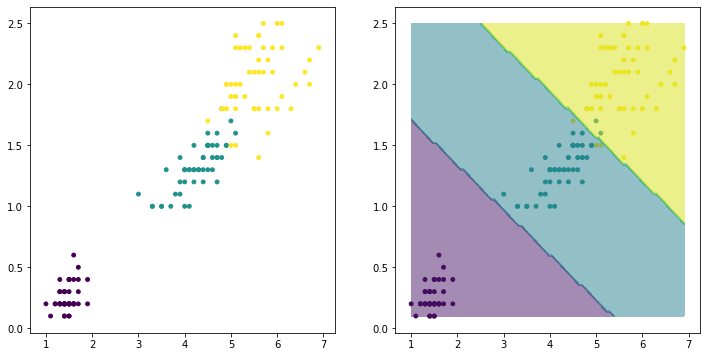

In [173]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=5000, verbose=500)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__TODO__:
- evitar overflow das funções de ativação
- mini-batch SGD
- early_stopping

```py
def stablesoftmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)
```

__NOTAS__:

__Inicialização dos pesos__:
- mostrar a documentação das funções np.random.rand e np.random.randn para mostrar como gerar distribuições na faixa [-limit, limit] e com média zero e certo desvio-padrão.
- mostrar que os métodos de inicialização de pesos ones e random_uniform podem não ser adequados para alguns problemas, como o do espiral binário.

__Regularização__:
- mostrar que a regularização dos pesos nem sempre ajuda. Em alguns casos, como o espiral multiclasse, temos que definir a reg_strength muito pequena. Isto é, estamos dizendo que o valores dos pesos não podem influenciar no custo. Em outras palavras, isso é a mesma coisa que "desligar" a regularização.